#Deep Learning Example with Keras

<i>Michelle Lochner</i>

This notebook illustrates how to use Keras (http://keras.io/) to create your own convolutional neural network (CNN) to run on your own dataset. 

This is taken from one of the Keras examples (https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py), with some added visualisation from https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb.

###A super brief introduction to CNNs

<b>Disclaimer</b>: I am not in any way an expert on deep learning or even on basic neural networks. None of the information below is guaranteed to be accurate. I will just add practical points, that I have figured out, to better understand how to make this algorithm work for your data.

These Stanford course notes http://cs231n.github.io/convolutional-networks/ are amazing, it doesn't take long to go through them and get a pretty good understanding of CNNs (and other neural nets too). I'll add a couple of images with descriptions from those notes to give you an idea of CNNs.

<b>Structure of neural networks</b>

This is the basic structure of any neural network, which were invented to attempt to emulate the connections found in the brain. Essentially it learns a non-linear transformation which converts input to output. Like any machine learning algorithm, you train it on some training data with known output. The hidden layers are made up of "neurons", which connect to every feature of the input, performing said non-linear transforms. Each neuron has a weight and these are learned from training data. 

<img src="neural_net2.jpeg",width=400>

<b>What makes convolutional neural networks different?</b>

It's usually quite rare to get much benefit from making neural networks more than one or two layers deep. CNNs are different because they can be dozens or even hundreds of layers deep.

CNNs are truly designed to work with images, it's built into their architecture (although it is possible to use them successfully on other types of features). Neurons (which actually tend to be called nodes or filters in CNN literature) now have volume instead of just being points. This is because they are designed to look at small pieces of the input image (this division of labour makes it possible to go so deep) within their little volume, called a "receptive field".

<img src="neural_net2a.jpeg">

The "convolution" part of convolutional neural networks refers to a particular type of layer, a convolutional layer, which is made up of filters that, when training, <i>slide</i> around the image, filtering bits of it (which is a convolution in effect) to see what filters get activated by what parts of the image.

The last thing I'll talk about is the fact that CNNs are not purely made of convolutional layers. There are several types, the most common of which are: fully connected or dense layers ("standard" neural network layers), convolutional layers, activation layers (which does the "what filters are activated by what" bit) such as "ReLu" layer, pooling layers (pool filters from previous layers and downsample) and dropout layers (which drop some of the weights to prevent overfitting). The best thing is to read the notes on these things. The most difficult part of deep learning is figuring out what combinations of layers to use, as there aren't any hard and fast rules. Here's an example network architecture:

<img src="convnet.jpeg",width=600>

##Using Keras to build a CNN for the MNIST dataset

We'll now build a CNN for the standard MNIST dataset, which is a dataset of thousands of small images of hand-written digits. The network will learn (very effectively) how to do handwriting recognition on these digits.

Note: Keras will run much faster if you install with an nvidia GPU.

Note2: There are several packages for deep learning, all based on theano and hence all with similar performance. nolearn (https://github.com/dnouri/nolearn) actually seems to have better documentation so may be better to use than Keras.

In [1]:
%matplotlib inline

In [12]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils

import theano

Load the data and split into a training dataset and a test dataset for validation.

In [5]:
nb_classes = 10 #The number of classes in your classification problem
# shape of the image (SHAPE x SHAPE)
shapex, shapey = 28, 28

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Reduce the size of the dataset, in the interest of speed.
ndat=10000
ntest=2000
X_train=X_train[:ndat]
Y_train=y_train[:ndat]
X_test=X_test[:ntest]
Y_test=y_test[:ntest]

#We do this reshaping because the CNN is always built to accept 3d arrays, usually the 2d array of an image 
#in 3 different colours (RGB). If you use something that isn't an image, you'll still have to reshape 
#each object's features to a 3d array
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

#It's important to normalise images when passing them to a CNN. You want all your features to be normalised to 1.
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')

10000 training samples
2000 test samples


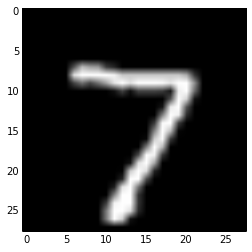

In [29]:
#An example image. Later we'll see how the network is activated when it sees this image.
ind=0
plt.imshow(X_test[ind][0],cmap='gray')

<b>The CNN architecture</b>

In [7]:
#The network performs an optimisation to minimise the difference between the input "true" classes and the output
#prediction. Batching splits up the input dataset so it only performs the optimisation on a (different) subset 
#of images each iteration. Reducing the batch_size greatly increases speed, at the cost of (some) accuracy
batch_size = 128 
nb_epoch = 10 #How many iterations to go through training the network. May need to be much larger for complex problems

# number of convolutional filters to use. Increasing this can improve accuracy. You can also try different numbers
# of filters for each layer, generally increasing the number as you go deeper.
nb_filters = 32
# level of pooling to perform (POOL x POOL). Very little reason to change this from 2.
nb_pool = 2
# level of convolution to perform (CONV x CONV). This is the receptive field size. (3x3) is the standard you should
# probably stick to
nb_conv = 3

<b>Network architecture</b>

We add two convolution layers, both activated with a standard activation layer, followed by pooling and some dropout to reduce overfitting.

If you get weird theano errors about array shapes mismatching, you probably put in some input dimensions wrong.
Convolution2D assumes the input (which is implied here) is of the shape:
 (nb_samples, stack_size, nb_row, nb_col)
nb_row and nb_col will usually be 3. nb_samples is just the number of samples which doesn't change. The stack_size <i>starts</i> as the third dimension size of your images (3 for RGB images, 1 for here) but <i>after</i> the convolutional layer, the stack_size will be the same as nb_filters so you need to update the stack_size parameter of the next layer accordingly. Also, the size of the dense layer has to be the total number of parameters in the network (which is quite large but smaller after pooling), hence the equation in the Dense layer.

The final "softmax" activation layer is what brings all the filters together to get a final classification, hence its output dimensions will always be the number of classes.

When compiling the model, you have to choose a loss function (usually categorical_crossentropy for classification, mean_squared_error for regression) and an optimizer, for which adadelta or adagrad work quite well.

In [8]:
#Now we build the actual model. We use the sequential model builder because I have no idea how the graph builder works
model = Sequential()


model.add(Convolution2D(nb_filters, 1, nb_conv, nb_conv, border_mode='full'))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_filters, nb_conv, nb_conv))
convout1=Activation('relu') #We need this for later visualisation
model.add(convout1)
model.add(MaxPooling2D(poolsize=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
# the resulting image after conv and pooling is the original shape
# divided by the pooling with a number of filters for each "pixel"
# (the number of filters is determined by the last Conv2D)
model.add(Dense(nb_filters * (shapex / nb_pool) * (shapey / nb_pool), 128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128, nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [ ]:
print(model.config) #This lets us look at the configuration of the architecture

<b>Training the model</b>

This can take quite a long time (even for the reduced dataset). As the network runs, it will print the loss function value (which should keep going down) and the accuracy for the training set. It will also then validate on the validation set after each epoch and print the loss and accuracy there. If the training accuracy is much higher than the validation accuracy, you are overfitting. To reduce overfitting you can decrease the complexity of the network, increase the size of your training set (such as using data augmentation) or (simple possible fix) increase the amount of dropout.

In [9]:
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 10000 samples, validate on 2000 samples
Epoch 0
10000/10000 [==============================] - 210s - loss: 0.7232 - acc: 0.7712 - val_loss: 0.2587 - val_acc: 0.9140
Epoch 1
10000/10000 [==============================] - 210s - loss: 0.2411 - acc: 0.9293 - val_loss: 0.1782 - val_acc: 0.9420
Epoch 2
10000/10000 [==============================] - 211s - loss: 0.1582 - acc: 0.9532 - val_loss: 0.1353 - val_acc: 0.9575
Epoch 3
10000/10000 [==============================] - 213s - loss: 0.1292 - acc: 0.9610 - val_loss: 0.1092 - val_acc: 0.9660
Epoch 4
10000/10000 [==============================] - 259s - loss: 0.1021 - acc: 0.9692 - val_loss: 0.0938 - val_acc: 0.9695
Epoch 5
10000/10000 [==============================] - 211s - loss: 0.0944 - acc: 0.9705 - val_loss: 0.0964 - val_acc: 0.9650
Epoch 6
10000/10000 [==============================] - 212s - loss: 0.0724 - acc: 0.9792 - val_loss: 0.0747 - val_acc: 0.9725
Epoch 7
10000/10000 [==============================] - 213s - loss: 0

<b>Visualising Keras output</b>

Here we plot the filters at a particular layer, once they've been <i>activated</i> by one of our test images. This shows what kind of training images the network has seen which look most like the test image.

In [10]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)
    
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic


In [13]:
convout1_f = theano.function([model.get_input(train=False)], convout1.get_output(train=False))

C1 shape :  (32, 28, 28)


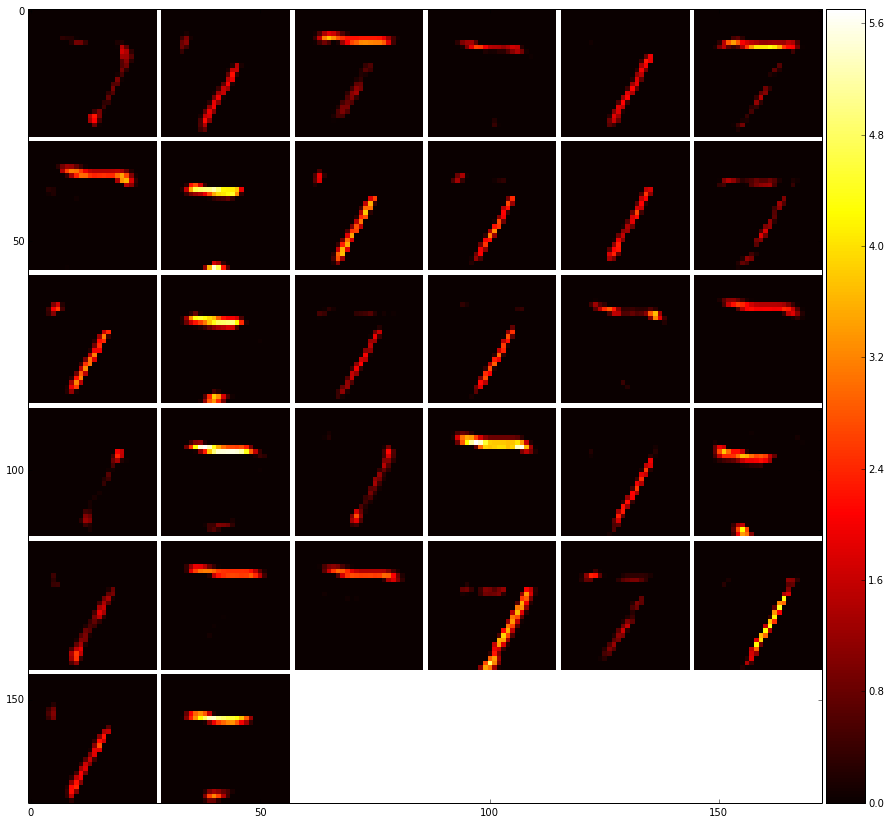

In [30]:
# Visualize convolution result (after activation)
C1 = convout1_f(X_test[ind:ind+1])
C1 = np.squeeze(C1)
print("C1 shape : ", C1.shape)

plt.figure(figsize=(15, 15))
nice_imshow(plt.gca(), make_mosaic(C1, 6, 6), cmap='hot')